In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import sys
print(os.listdir('../input'))

# Any results you write to the current directory are saved as output.

['lr2model', 'resized-2015-2019-blindness-detection-images', 'resnet50', 'aptos2019-blindness-detection', 'wide-resnet-customed']


In [2]:
import torch
from tqdm import tqdm, tqdm_notebook
import random, torch, os, numpy as np
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
import scipy as sp

torch.backends.cudnn.deterministic = True

# def seed_everything(seed):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

# SEED = 999
# seed_everything(SEED)

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from zipfile import ZipFile
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.vision import *
from fastai.callbacks import *
from sklearn.metrics import confusion_matrix, cohen_kappa_score

In [5]:
bs = 96

!ls

__notebook__.ipynb  __output__.json


In [6]:
# # copy pretrained weights for resnet50 to the folder fastai will search by default
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
# !cp '../input/resnet50/resnet50.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'
#resnet50-19c8e357
#resnet34-333f7ec4

In [7]:
print(os.listdir('../input/resized-2015-2019-blindness-detection-images/'))

['resized test 15', 'labels', 'resized train 15', 'resized test 19', 'resized train 19']


In [8]:
def get_df():
    base_image_dir = os.path.join('..', 'input/resized-2015-2019-blindness-detection-images/')
    train_dir = os.path.join(base_image_dir,'resized train 15/')
    df = pd.read_csv(os.path.join(base_image_dir, 'labels/trainLabels15.csv'))
    df['path'] = df['image'].map(lambda x: os.path.join(train_dir,'{}.jpg'.format(x)))
    df = df.drop(columns=['image'])
    df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
    test_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
    return df, test_df

df, test_df = get_df()

   level                                               path
0      0  ../input/resized-2015-2019-blindness-detection...
1      0  ../input/resized-2015-2019-blindness-detection...
2      1  ../input/resized-2015-2019-blindness-detection...
3      0  ../input/resized-2015-2019-blindness-detection...
4      2  ../input/resized-2015-2019-blindness-detection...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feecb898278>]], dtype=object)

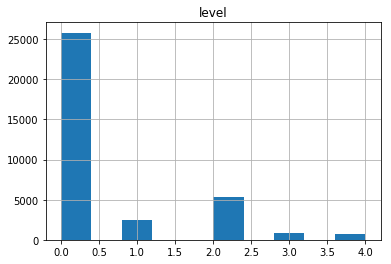

In [9]:
print(df.head())
df.hist()

In [10]:
df = df.rename(columns={"level": "diagnosis"})

In [11]:
remove_n = 9000
drop_indices = np.random.choice(df[df.diagnosis==0].index, remove_n, replace=False)
df_sub = df.drop(drop_indices)

17416 8710


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


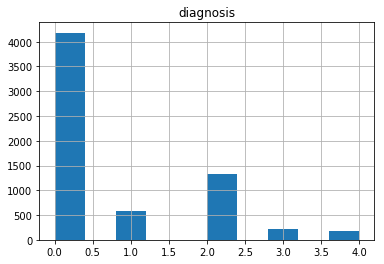

In [12]:
# create Stratified validation split (12.50%)
#fastai does not include stratify option in train test data split, however according to the lecturer, 
#imbalance classifiers will be handle by the deep learning quite well, not sure this is true in this case
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=3, random_state=999)
tr_ids, val_ids = next(cv.split(df_sub.path, df_sub.diagnosis))
print(len(tr_ids), len(val_ids))
_ = df_sub.loc[val_ids].hist()

In [13]:
# print(val_ids)
# print(tr_ids)

In [14]:
# import zipfile
# with zipfile.ZipFile('./train_images.zip', 'r') as zip_ref:
#     zip_ref.extractall('./train_images')

In [15]:
# with zipfile.ZipFile('./test_images.zip', 'r') as zip_ref:
#     zip_ref.extractall('./test_images')

In [16]:
tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0.3, 1), 'col_pct': (0.1, 0.9), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (rgb_randomize), kwargs={'channel':0, 'thresh':0.1}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (rgb_randomize), kwargs={'channel':2, 'thresh':0.1}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-15.0, 15.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.01), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])


In [17]:
#create data using fastai ImageDataBunch function, create from image list with lable.
#simple data augmentation with flip and rotate since this is an eyeball image, the image is normalized using default imagenet_stats, another possible 
#option would be use the aptos19_stats, which not sure how to derive from yet
# create image data bunch
# 
# create image data bunch
# data = ImageDataBunch.from_df('./', 
#                               df=df, 
#                               valid_pct=0.2,
#                               folder="../input/diabetic-retinopathy-resized/resized_train",
#                               suffix=".jpeg",
#                               ds_tfms=tfms,
#                               size=224,
#                               resize_method=ResizeMethod.SQUISH,
#                               bs=96, 
#                               num_workers=0,
#                              label_col='level', label_delim=',').normalize(imagenet_stats)

In [18]:
data = (ImageList.from_df(df=df_sub,path='./', cols='path') 
        .split_by_idx(val_ids) 
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=224) 
        .databunch(bs=96,num_workers=16) 
        .normalize(imagenet_stats)  
       )

In [19]:
# data.show_batch(rows=3, figsize=(7,6))

In [20]:
import torchvision.models as models
wide_resnet50_2 = models.wide_resnet50_2(pretrained=False)
model = nn.Sequential(
#     nn.Conv2d(1, 8, 3, padding=1, bias=False),           # conv1
#     *wresgroup(8, 8, k=2, N=6, dropout=0.3),             # conv2
#     *wresgroup(16, 16, k=2, N=6, stride=2, dropout=0.3), # conv3
#     *wresgroup(32, 32, k=2, N=6, stride=2, dropout=0.3), # conv4
    wide_resnet50_2,
#     nn.BatchNorm2d(1000),
    nn.ReLU(inplace=True),
#     nn.AvgPool2d(1),                                     # the output of the last wresgroup is 7x7
    Flatten(),
    nn.Linear(1000, 1)
)

In [21]:
# optar = partial(Ranger)

In [22]:
def quad_kappa(y_pred, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')

In [23]:
learn = Learner(data, model, metrics=quad_kappa,
#                     loss_func = MSELossFlat(),
#                     opt_func = optar,
                    callback_fns=[
                              partial(EarlyStoppingCallback, monitor='quad_kappa', min_delta=0.001, patience=2),
                              partial(ReduceLROnPlateauCallback),
                              partial(SaveModelCallback, every = 'improvement', monitor='quad_kappa', name='bestmodel')],
                    model_dir="/tmp/")

In [24]:
!cp '../input/wide-resnet-customed/wideresnet-50-2-customed.pth' '/tmp/'
learn.load('wideresnet-50-2-customed')
learn.to_fp16()
learn.summary;

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-03


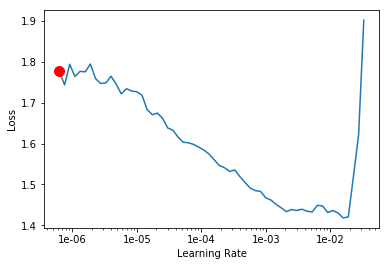

In [26]:
learn.recorder.plot(suggestion=True)

In [27]:
# lrs = learn.recorder.lrs
# losses = learn.recorder.losses
# mg = (np.gradient(np.array(losses))).argmin()
# ml = np.argmin(losses)
# min_grad_lr = lrs[mg]
# print(min_grad_lr)
# min_loss_lr0 = lrs[ml]/10
# print(min_loss_lr0)
min_loss_lr0 = 1.4e-4

In [28]:
learn.fit_one_cycle(10,min_loss_lr0)

epoch,train_loss,valid_loss,quad_kappa,time
0,0.982107,0.905861,0.376719,14:33
1,0.822014,0.719221,0.549243,14:27
2,0.749906,0.725504,0.495408,14:52
3,0.710337,0.756191,0.597555,15:33
4,0.684553,0.602773,0.628820,15:48
5,0.616835,0.631540,0.616581,15:56
6,0.595445,0.573012,0.639670,15:57
7,0.530958,0.518078,0.692483,16:00
8,0.487567,0.501542,0.703500,15:59
9,0.478898,0.496420,0.701592,15:55


Better model found at epoch 0 with quad_kappa value: 0.3767193555831909.
Better model found at epoch 1 with quad_kappa value: 0.5492425560951233.
Epoch 2: reducing lr to 2.8e-05
Epoch 3: reducing lr to 2.6613569696377266e-05
Better model found at epoch 3 with quad_kappa value: 0.5975550413131714.
Better model found at epoch 4 with quad_kappa value: 0.6288200616836548.
Epoch 5: reducing lr to 1.7115336614216096e-05
Better model found at epoch 6 with quad_kappa value: 0.6396703124046326.
Better model found at epoch 7 with quad_kappa value: 0.6924829483032227.
Better model found at epoch 8 with quad_kappa value: 0.7035004496574402.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 6.31E-08
1.7378008287493754e-07
3.019951720402016e-08


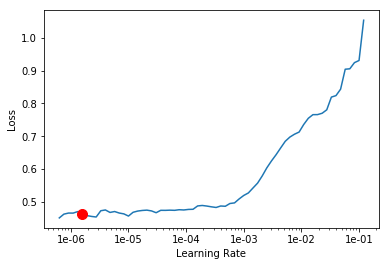

In [29]:
learn.load('bestmodel')
learn.unfreeze()
learn.lr_find()
lrs = learn.recorder.lrs
losses = learn.recorder.losses
learn.recorder.plot(suggestion=True)
mg = (np.gradient(np.array(losses))).argmin()
ml = np.argmin(losses[1:])
min_grad_lr = lrs[mg]
print(min_grad_lr)
min_loss_lr = lrs[ml]/10
print(min_loss_lr)

In [30]:
learn.fit_one_cycle(10,max_lr = min_loss_lr)

epoch,train_loss,valid_loss,quad_kappa,time
0,0.473618,0.500702,0.702937,16:00
1,0.488964,0.500645,0.704118,15:58
2,0.478421,0.501442,0.701201,15:54
3,0.497274,0.503435,0.699931,15:08


Better model found at epoch 0 with quad_kappa value: 0.7029368877410889.
Better model found at epoch 1 with quad_kappa value: 0.7041178345680237.
Epoch 2: reducing lr to 6.039903440804033e-09
Epoch 3: reducing lr to 5.740835399329535e-09
Epoch 4: early stopping
Epoch 4: reducing lr to 4.902865368348894e-09


In [31]:
learn.freeze()
learn.fit_one_cycle(5,min_loss_lr0/100)

AssertionError: 

In [32]:
!cp '../input/lr2model/stage-2r.pth' '/tmp/'

In [33]:
base_image_dir2 = os.path.join('..', 'input/aptos2019-blindness-detection/')
train_dir2 = os.path.join(base_image_dir2,'train_images/')
df2 = pd.read_csv(os.path.join(base_image_dir2, 'train.csv'))
df2['path'] = df2['id_code'].map(lambda x: os.path.join(train_dir2,'{}.png'.format(x)))
df2 = df2.drop(columns=['id_code'])
df2 = df2.sample(frac=1).reset_index(drop=True) #shuffle dataframe

In [34]:
data2 = (ImageList.from_df(df=df2,path='./',cols='path') 
        .split_by_rand_pct(0.25) 
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=224,padding_mode='zeros') 
        .databunch(bs=156,num_workers=16) 
        .normalize(imagenet_stats)  
       )
# learn.load('stage-2r')
learn.data = data2
learn.to_fp16()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.20E-04
1e-07


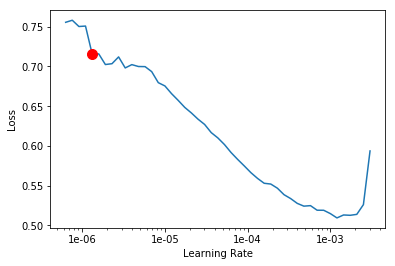

In [35]:
# learn.recorder.plot(suggestion=True)
lrs = learn.recorder.lrs
losses = learn.recorder.losses
learn.recorder.plot(suggestion=True)
mg = (np.gradient(np.array(losses))).argmin()
ml = np.argmin(losses)
min_grad_lr = lrs[mg]
print(min_grad_lr)
min_loss_lr = lrs[ml]/10

In [36]:
# !cp '../input/newcrop/bestmodel3.pth' '/tmp/'
# !ls /tmp

In [37]:
# learn.save('stage-1');
# learn.unfreeze()
# learn.lr_find(start_lr = 1e-10)

In [38]:
# learn.recorder.plot(suggestion=True)

In [39]:
learn.fit_one_cycle(10, min_loss_lr)
# learn.freeze_to(-3)
# learn.fit_one_cycle(10,slice(1e-6,1e-4))
learn.unfreeze()
learn.fit_one_cycle(10,slice(min_loss_lr/200,min_loss_lr/50))
learn.freeze()
learn.fit_one_cycle(5,min_loss_lr/100)

epoch,train_loss,valid_loss,quad_kappa,time
0,0.554113,0.381143,0.878228,08:56
1,0.439281,0.307578,0.893438,09:07
2,0.380288,0.289043,0.896794,09:19
3,0.343710,0.257154,0.910172,09:29
4,0.311889,0.249265,0.909132,09:31
5,0.289415,0.245484,0.911535,09:35
6,0.264542,0.248203,0.914639,09:43
7,0.244846,0.237119,0.920728,09:40
8,0.227872,0.240375,0.920818,09:38
9,0.214136,0.239414,0.920376,09:29


Better model found at epoch 0 with quad_kappa value: 0.8782282471656799.
Better model found at epoch 1 with quad_kappa value: 0.8934376239776611.
Better model found at epoch 2 with quad_kappa value: 0.8967943787574768.
Better model found at epoch 3 with quad_kappa value: 0.9101716876029968.
Better model found at epoch 5 with quad_kappa value: 0.9115345478057861.
Epoch 6: reducing lr to 9.34741308937644e-06
Better model found at epoch 6 with quad_kappa value: 0.9146387577056885.
Better model found at epoch 7 with quad_kappa value: 0.9207280278205872.
Epoch 8: reducing lr to 1.190707499098653e-06
Better model found at epoch 8 with quad_kappa value: 0.9208178520202637.
Epoch 9: reducing lr to 9.618115476939304e-11


ZeroDivisionError: division by zero

In [40]:
learn.load('bestmodel');
# valid_preds = learn.get_preds(ds_type=DatasetType.Valid)
# train_preds = learn.get_preds(ds_type=DatasetType.Train)

In [41]:
#https://www.kaggle.com/abhishek/optimizer-for-quadratic-weighted-kappa
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [42]:
sample_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [43]:
learn.data.add_test(ImageList.from_df(sample_df,'../input/aptos2019-blindness-detection',folder='test_images',suffix='.png'))

In [44]:
def run_subm(learn=learn, coefficients=[0.57, 1.57, 2.57, 3.57])
    opt = OptimizedRounder()
    preds,y = learn.get_preds(DatasetType.Test)
    tst_pred = opt.predict(preds, coefficients)
    sample_df.diagnosis = tst_pred.astype(int)
    sample_df.to_csv('submission.csv',index=False)
    print ('done')

SyntaxError: invalid syntax (<ipython-input-44-c8d35981bfa2>, line 1)

In [45]:
coefficients=[0.57, 1.57, 2.57, 3.57]
opt = OptimizedRounder()
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = opt.predict(preds, coefficients)
sample_df.diagnosis = tst_pred.astype(int)
sample_df.diagnosis.value_counts()

2    953
3    359
0    337
1    246
4     33
Name: diagnosis, dtype: int64

In [46]:
run_subm()

NameError: name 'run_subm' is not defined

In [47]:
!mv {learn.model_dir}/*.pth .
os.listdir()

['stage-2r.pth',
 'tmp.pth',
 'wideresnet-50-2-customed.pth',
 '__notebook__.ipynb',
 'bestmodel.pth',
 '__output__.json']